# Data
(Source: [LA Sheriff](http://shq.lasdnews.net/CrimeStats/CAASS/desc.html))
Archive files come by year ( 50MB to 65MB about Xe5 records per file )
with ~30 categories and short verbal description of semi-structured dictionary.

Location is X,Y geocode State Plane 5 format.
Depend on crime category location and time might be missing.
Location might be recovered via ZIPcode and vise verse for some records.

The current data comes as a daily updated 30 days window in the same format.

### 1. Download
<pre>
START_YEAR=2005
CURRENT_YEAR=$(date +'%Y')
DIR=$(cd "$( dirname "${BASH_SOURCE[0]}" )" && pwd)

if [ -d $DIR/archive ]; then
    echo "Local archive exists"
else
    mkdir $DIR/archive
fi

if ! [ -d $DIR/data ]; then
    mkdir $DIR/data
fi

let Y=$START_YEAR
while [[ $Y -lt $CURRENT_YEAR ]]
do
    if [ -f $DIR/archive/$Y-PART_I_AND_II_CRIMES.csv.gz ]; then
        echo "$Y using local archive..."
        gzip -d $DIR/archive/$Y-PART_I_AND_II_CRIMES.csv.gz
    else
        curl -o $DIR/archive/$Y-PART_I_AND_II_CRIMES.csv \
                http://shq.lasdnews.net/CrimeStats/CAASS/$Y-PART_I_AND_II_CRIMES.csv
    fi

    tr '[:upper:]' '[:lower:]' < $DIR/archive/$Y-PART_I_AND_II_CRIMES.csv > $DIR/data/$Y.csv
    perl -pi -e 's/[[:^ascii:]]//g' $DIR/data/$Y.csv
    sed -i '1!b;s/"//g' $DIR/data/$Y.csv
    gzip $DIR/archive/$Y-PART_I_AND_II_CRIMES.csv
    ((Y = Y + 1))
done
</pre>

### 2. Audit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/2010.csv')
df.head()

,incident_date,incident_reported_date,category,stat,stat_desc,address,street,city,zip,x_coordinate,y_coordinate,incident_id,reporting_district,seq,gang_related,unit_id,unit_name,deleted
0,1/1/2010 3:48:00 am,1/1/2010,vehicle / boating laws,255,vehicle and boating laws: misdemeanor,"albertoni st & broadway, carson, ca",albertoni st & broadway,carson,NaN,6.477110e+06,1.775513e+06,910-00007-1610,1610,7,no,ca0190016,carson,n
1,1/1/2010 3:35:00 am,1/1/2010,drunk driving vehicle / boat,242,drunk driving - vehicle/boat: alc/drugs,"2718 evelyn ave, rosemead, ca 91770",2718 evelyn ave,rosemead,91770.0,6.531129e+06,1.844414e+06,910-00007-0532,532,7,no,ca0190005,temple,n
2,1/1/2010 4:13:00 am,1/1/2010,larceny theft,389,"theft, petty: other (from prvt res, boat, plan...","888 e dominguez st, carson, ca 90745",888 e dominguez st,carson,90745.0,6.482744e+06,1.764384e+06,910-00009-1620,1620,9,no,ca0190016,carson,n
3,1/1/2010 2:40:00 am,1/1/2010,vehicle / boating laws,251,"vehicle and boating laws: hit and run, felony ...","diamond bar blvd & sunset crossing rd, diamond...",diamond bar blvd & sunset crossing rd,diamond bar,91765.0,6.619060e+06,1.832842e+06,910-00004-2920,2920,4,no,ca0190020,walnut,n
4,1/1/2010 12:30:00 am,1/1/2010,burglary,72,"burglary, other structure: night, entry no force","21951 golden springs dr, diamond bar, ca",21951 golden springs dr,diamond bar,NaN,6.612401e+06,1.823096e+06,910-00005-2922,2922,5,no,ca0190020,walnut,n


In [3]:
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['incident_reported_date'] = pd.to_datetime(df['incident_reported_date'])

In [4]:
year = df['incident_date'].apply(lambda d: d.strftime('%Y'))
miss = len(year[year != '2010'])
print('{:.2f}% ({})'.format(100 * miss/len(year), miss))

2.67% (5507)


In [5]:
miss = len(df[(df['zip'].isnull()) & (df['x_coordinate'].isnull()) & (df['y_coordinate'].isnull())])
print('{:.2f}% ({})'.format(100 * miss/len(df), miss))

6.14% (12670)


In [6]:
for f in ['category', 'stat', 'stat_desc', 'reporting_district', 'seq', 'gang_related', 'deleted']:
    stats = df.groupby([f]).size().reset_index(name='count').sort_values('count', ascending = False)
    print('{}: {}'.format(f.upper(), len(stats)))

CATEGORY: 29
STAT: 244
STAT_DESC: 244
REPORTING_DISTRICT: 1342
SEQ: 28475
GANG_RELATED: 2
DELETED: 2



 CATEGORY: 29
------------------------------------------------
                   category  count
26   vehicle / boating laws  33101
15            larceny theft  32913
18                narcotics  30275
2                  burglary  14486
19  non-aggravated assaults  13662
25                vandalism  13589
14         grand theft auto  11624
12     fraud and nsf checks  10383
0        aggravated assault   7848
22                  robbery   5242


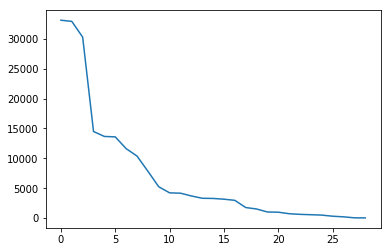


 STAT_DESC: 244
------------------------------------------------
                                             stat_desc  count
220              vehicle and boating laws: misdemeanor  27612
157  narcotics: marijuana misdemeanors (less than 1...  10726
101  grand theft vehicle (gta): automobile/passenge...   9608
224      vehicle burglary: auto/passenger van burglary   8671
153  narcotics: barbiturates etc or any sched iii, ...   6318
20           assault, non-agg: hands, feet, fist, etc.   5732
23          assault, non-aggravated: domestic violence   5669
207  theft, petty: shoplifting (from dept store, mk...   5607
213                                     vandalism misd   5301
155  narcotics: heroin, etc or sched i or ii drugs ...   5239


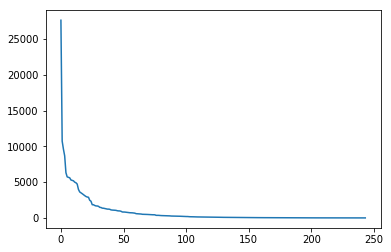


 GANG_RELATED: 2
------------------------------------------------
  gang_related   count
0           no  198614
1          yes    7715

 DELETED: 2
------------------------------------------------
  deleted   count
0       n  206328
1       y       1


In [7]:
for f in ['category', 'stat_desc', 'gang_related', 'deleted']:
    stats = df.groupby([f]).size().reset_index(name='count').sort_values('count', ascending = False)
    print('\n {}: {}'.format(f.upper(), len(stats)))
    print('------------------------------------------------')
    print(stats.head(10))
    if len(stats) > 2:
        plt.plot(stats['count'].tolist())
        plt.show()

In [8]:
categories = set(df.groupby(['category']).size().reset_index(name='count')['category'].tolist())
categories

{'aggravated assault',
 'arson',
 'burglary',
 'criminal homicide',
 'disorderly conduct',
 'drunk / alcohol / drugs',
 'drunk driving vehicle / boat',
 'federal offenses w/o money',
 'federal offenses with money',
 'felonies',
 'forcible rape',
 'forgery',
 'fraud and nsf checks',
 'gambling',
 'grand theft auto',
 'larceny theft',
 'liquor laws',
 'misdemeanors',
 'narcotics',
 'non-aggravated assaults',
 'offenses against family',
 'receiving stolen property',
 'robbery',
 'sex offenses',
 'vagrancy',
 'vandalism',
 'vehicle / boating laws',
 'warrants',
 'weapon laws'}

### 3. Cleaning

In [9]:
columns = sorted(df.columns)

# let's see some
for Y in [2005, 2009, 2013, 2016]:
    df = pd.read_csv('data/{}.csv'.format(Y))
    print('\n--- {} --------------------'.format(Y))
    
    cat = set(df.groupby(['category']).size().reset_index(name='count')['category'].tolist())
    if sorted(df.columns) == columns:
        for f in ['category', 'stat', 'stat_desc']:
            stats = df.groupby([f]).size().reset_index(name='count').sort_values('count', ascending = False)
            print('{}: {}'.format(f.upper(), len(stats)))
            
        print('Categories common: {}\nextra: {}\nmiss: {}'\
              .format(len(cat & categories), list(cat - categories), list(categories - cat)))
        
        date = pd.to_datetime(df['incident_date'], errors = 'ignore')
        year = date.apply(lambda d: d if type(d) == str else d.strftime('%Y'))
        miss = len(year[year != str(Y)])
        print('Date miss: {:.2f}% ({})'.format(100 * miss/len(year), miss))
        n = np.random.randint(100,10000)
        print('{} | {} | {}'.format(df.loc[n,'incident_date'], date[n], year[n]))
        miss = len(df[(df['zip'].isnull()) & (df['x_coordinate'].isnull()) & (df['y_coordinate'].isnull())])
        print('Location miss: {:.2f}% ({})'.format(100 * miss/len(df), miss))
    else:
        print('Columns mismatch: {}'.format(sorted(df.columns)))


--- 2005 --------------------
CATEGORY: 29
STAT: 249
STAT_DESC: 249
Categories common: 29
extra: []
miss: []
Date miss: 100.00% (215208)
1/12/2005 3:00:00 pm | 1/12/2005 3:00:00 pm | 1/12/2005 3:00:00 pm
Location miss: 6.96% (14980)

--- 2009 --------------------
CATEGORY: 29
STAT: 247
STAT_DESC: 247
Categories common: 29
extra: []
miss: []
Date miss: 2.89% (6052)
1/14/2009 11:15:00 pm | 2009-01-14 23:15:00 | 2009
Location miss: 6.40% (13396)

--- 2013 --------------------
CATEGORY: 30
STAT: 244
STAT_DESC: 244
Categories common: 26
extra: ['felonies miscellaneous', 'sex offenses misdemeanors', 'misdemeanors miscellaneous', 'sex offenses felonies']
miss: ['felonies', 'misdemeanors', 'sex offenses']
Date miss: 2.26% (3841)
04/19/2013 08:30:00 pm | 2013-04-19 20:30:00 | 2013
Location miss: 3.24% (5512)

--- 2016 --------------------
CATEGORY: 39
STAT: 328
STAT_DESC: 328
Categories common: 26
extra: ['sex offenses misdemeanors', 'accidents traffic/veh./boat', 'felonies miscellaneous', 'co

Problems to fix: CATEGORY inconsistency and date parsing. For location we can relay on zipcode or coordinates and drop address and street fields which are somewhat messy. 
We are going to split the incident date field into year, month, day, weekday and hour features with the goal to [predict crime category by season, time and location](Modeling.ipynb). )

In [10]:
drop = ['misdemeanors','sex offenses misdemeanors','miscellaneous non-criminal','misdemeanors miscellaneous',
        'juvenile non-criminal','commitments','disorderly conduct','mentally ill',
        'accidents miscellaneous','accidents traffic/veh./boat',
        'suicide and attempt','persons dead','persons missing','receiving stolen property']

def collapse(x):
    if x == 'criminal homicide':
        return 'homicide'
    if x == 'forcible rape':
        return 'rape'
    if x == 'grand theft auto':
        return 'gta'
    if x[:13] == 'drunk driving':
        return 'dui'
    if x == 'offenses against family':
        return 'family'
    if 'assault' in x:
        return 'assault'
    return x.split()[0]

In [11]:
def yes_no(x):
    x = x.lower()
    if x[0] == 'n':
        return 0
    if x[0] == 'y':
        return 1
    return

In [12]:
import re
import datetime

def extract(d):
    Y, M, D, W, H = (None for _ in range(5))
    
    def get_hour(groups):
        H, m, s = (int(x) for x in groups[4:7])
        if groups[8] == 'am' and H == 12:
            H = 0
        if groups[8] == 'pm' and 0 < H < 12:
            H += 12
        return H + m/60 + s/3600
        
    if type(d) == str:
        d = d.lower()
        match = re.match(r'^(\d+)/(\d+)/(20\d+)( (\d+):(\d+):(\d+)( (am|pm))?)?', d)
        if match is None:
            match = re.match(r'^(\d+)-([a-z]+)-(\d+)( (\d+):(\d+):(\d+)( (am|pm))?)?', d)
            if match is None:
                return
            else:
                month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
                D = int(match.group(1))
                M = month.index(match.group(2)) + 1
                Y = 2000 + int(match.group(3))
                W = datetime.date(Y, M, D).timetuple()[6]
                if match.group(4) is None:
                    H = -1
                else:
                    H = get_hour(match.groups())
        else:
            M, D, Y = (int(x) for x in (match.groups())[:3])
            W = datetime.date(Y, M, D).timetuple()[6]
            if match.group(4) is None:
                H = -1
            else:
                H = get_hour(match.groups())
    return (Y, M, D, W, H)


Missing coordinates could be inferred from zipcode and backwards. (For this conversion, and for the maps we need latitude and longitude.)

In [13]:
from pyproj import Proj, transform
projection = Proj(' '.join(['+proj=lcc','+lat_1=34.03333333333333','+lat_2=35.46666666666667',
                            '+lat_0=33.5','+lon_0=-118','+x_0=2000000','+y_0=500000','+ellps=GRS80',
                            '+units=us-ft','+no_defs']), preserve_units = True)

def to_lonlat(r):
    x, y = r['x_coordinate'], r['y_coordinate']
    if np.isnan(x) or np.isnan(y):
        return None, None
    return projection(x, y, inverse = True)


In [14]:
import os
import MySQLdb as db
con = db.connect(os.environ['MYSQL_HOST'], os.environ['DATAUSER'],
                 os.environ['MYSQL_PASS'], os.environ['DATABASE'],
                 int(os.environ['MYSQL_PORT']))

zip_to_lonlat = pd.read_sql("""
    SELECT zip, longitude, latitude
    FROM usps_zcta5
    WHERE state = 'CA'
    """, con = con)


def fix_location(r):
    # all is fine: just change datatype to str
    if not np.isnan(r['zip']) and not np.isnan(r['latitude']):
        return [str(int(r['zip'])), r['longitude'], r['latitude']]
    
    # try to locate within zipcode polygons
    if not np.isnan(r['latitude']):
        query = """
        SELECT t.geoid as zip, {} as longitude, {} as latitude
        FROM us_zcta5 t JOIN usps_zcta5 z ON t.geoid = z.zip
        WHERE st_contains(t.shape, ST_GeomFromText('POINT({} {})', 2))
        """
        res = pd.read_sql(query.format(r['longitude'], r['latitude'],
                                       r['longitude'], r['latitude']), con = con)
        if len(res) == 1:
            return res.values[0].tolist()

    # use zipcode center as location proxy
    if not np.isnan(r['zip']):
        res = zip_to_lonlat[zip_to_lonlat['zip'] == str(int(r['zip']))]
        if len(res) == 1:
            return res.values[0].tolist()

    return [None, None, None]


In [15]:
for Y in range(2005, datetime.date.today().timetuple()[0]):
    df = pd.read_csv('data/{}.csv'.format(Y), low_memory = False)
    print('\n--- {} --------------------'.format(Y))

    # remove `deleted` records
    df['deleted'] = df['deleted'].apply(yes_no)
    df = df[df['deleted'] == 0]

    # remove misc misdemeanors
    df = df[~df['category'].isin(drop)]

    # validate date and expand into Y,N,D,W,H
    df['dt'] = df['incident_date'].apply(extract)
    df = df[~df['dt'].isnull()]

    # convert from plane state to lat,lng
    df['ll'] = df.apply(to_lonlat, axis = 1)

    # init features
    features = df.loc[:,['category', 'stat', 'stat_desc', 'city', 'zip']]
    dt = ['year', 'month', 'day', 'weekday', 'hour']
    for i in range(len(dt)):
        features[dt[i]] = df['dt'].apply(lambda x: x[i] )

    features['longitude'] = df['ll'].apply(lambda x: x[0])
    features['latitude'] = df['ll'].apply(lambda x: x[1])

    features['gang_related'] = df['gang_related'].apply(yes_no)
    features['aggravated'] = df['category'].apply(lambda x: 1 if x[:10] == 'aggravated' else 0)

    features['category'] = df['category'].apply(collapse)
    cat = set(features.groupby(['category']).size().reset_index(name='count')['category'].tolist())
    print('Categories: {}'.format(len(cat)))
    
    print('Date miss: {:.4f}%'\
        .format(100 * (1 - len(features[(features['year'] > 2000) & (~features['weekday'].isnull())])/len(features))))
    print('Location miss: {:.4f}%'\
        .format(100 * (1 - len(features[(features['zip'] > 0) | (features['latitude'] > 0)])/len(features))))

    # keep records with valid date
    features['incident_date'] = df['dt'].apply(lambda x: datetime.date(x[0], x[1], x[2]))
    features = features[(features['year'] > 2000) & (~features['weekday'].isnull())]
    print('Time miss: {:.4f}%'.format(100 * len(features[features['hour'] == -1])/len(features)))
    # potential `exact-time-unknown` issue
    print('Hour ZERO: {:.4f}%'.format(100 * len(features[features['hour'] == 0])/len(features)))
    print('Hour NOON: {:.4f}%'.format(100 * len(features[features['hour'] == 12])/len(features)))
    
    features = features[(features['zip'] > 0) | (features['latitude'] > 0)]
    
    # try to infer partial location where possible
    features[['zip','longitude','latitude']] = features[['zip','longitude','latitude']]\
                                                    .apply(fix_location, axis = 1)
    print('Failed location fix: {:.4f}%'\
        .format(100 * len(features[features['zip'].isnull()])/len(features)))
    features = features[~features['zip'].isnull()]
    
    # reduce to LA bounding-box
    features = features[(features['longitude'] > -119) & (features['longitude'] < -116)]
    features = features[(features['latitude'] > 32) & (features['latitude'] < 35)]
    
    features.to_csv('data/F{}.csv'.format(Y), index = False)



--- 2005 --------------------
Categories: 24
Date miss: 0.0764%
Location miss: 6.9730%
Time miss: 4.7489%
Hour ZERO: 0.0000%
Hour NOON: 2.0184%
Failed location fix: 0.0333%

--- 2006 --------------------
Categories: 24
Date miss: 0.0534%
Location miss: 7.2422%
Time miss: 4.6694%
Hour ZERO: 0.0000%
Hour NOON: 1.9773%
Failed location fix: 0.0478%

--- 2007 --------------------
Categories: 24
Date miss: 0.0525%
Location miss: 6.8407%
Time miss: 4.8200%
Hour ZERO: 0.0000%
Hour NOON: 1.8658%
Failed location fix: 0.0693%

--- 2008 --------------------
Categories: 24
Date miss: 0.0343%
Location miss: 6.3251%
Time miss: 4.8416%
Hour ZERO: 0.0000%
Hour NOON: 1.9340%
Failed location fix: 0.1076%

--- 2009 --------------------
Categories: 24
Date miss: 0.0306%
Location miss: 6.3597%
Time miss: 4.8351%
Hour ZERO: 0.0000%
Hour NOON: 1.9233%
Failed location fix: 0.1314%

--- 2010 --------------------
Categories: 24
Date miss: 0.0335%
Location miss: 6.1093%
Time miss: 4.7572%
Hour ZERO: 0.0000%
Hour